In [2]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns
import helper
import algorithms

from matplotlib.lines import Line2D

from scipy.optimize import curve_fit



In [5]:
num_iterations = 1000

file_name = 'geometric_dperish'

mean_size = 2
var_size = .1

num_groups = 150

EPS = 0.005

alpha_grid = np.arange(0, 1+EPS, EPS)


In [6]:
def demand_dist(n, mean_size, var_size=.1):
    size = np.maximum(0, np.random.normal(loc=mean_size, scale=np.sqrt(var_size), size=n))
    return size

In [12]:


data = []
for alpha in alpha_grid:
    print(f"Parameter alpha: {alpha}")

    def perish_dist(b, n):
        val = np.minimum(n,np.random.geometric(p = (n)**((-1)*(1+alpha))))
        return val
        
    n = num_groups    

    max_budget = mean_size*n
    order = np.arange(0,max_budget,1)

    offset_prob = helper.check_offset_expiry(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget)
    # print(f' Probability process is offset expiring: {100*offset_prob}')

    # CALCULATES
    n_upper = helper.n_upper(lambda n: demand_dist(n, mean_size, var_size), n)
    
    x_lower_perish = helper.x_lower_line_search(perish_dist, lambda n: demand_dist(n, mean_size, var_size), n, max_budget, n_upper, order)
    x_lower_no_perish = (max_budget / n_upper[0])

    dperish = (max_budget / n_upper[0]) - x_lower_perish
    
    # print(f'Necessary X_lower due to perishing: {x_lower_perish} and dperish: {dperish}')
    print(f"N: {n}, dPerish: {dperish}")

    data_dict = {'NumGroups': n, 'Alpha': alpha, 'Epsilon': EPS, 'Allocation': 'X Lower', 'Value': x_lower_perish}
    data.append(data_dict)

Parameter alpha: 0.0
N: 150, dPerish: 0.4800000000000004
Parameter alpha: 0.005


KeyboardInterrupt: 

In [7]:
# df = pd.DataFrame.from_records(data)
# df.to_csv('./data/'+file_name+'.csv', index=False)
df = pd.read_csv('./data/'+file_name+'.csv')

In [8]:
df_fit = df.groupby('Alpha')['Value'].mean()
print(df_fit)



Alpha
0.000    0.426974
0.005    0.446724
0.010    0.448187
0.015    0.457864
0.020    0.468443
           ...   
0.980    0.889864
0.985    0.887771
0.990    0.888627
0.995    0.886969
1.000    0.887252
Name: Value, Length: 201, dtype: float64


In [10]:
def func(x, a, b):
    return a - b * (150**((-1) * x))
initial_guess = [0.9, 0.9]

params, covariance = curve_fit(func, df_fit.index, df_fit.values, p0=initial_guess)

print("Fitted Parameters:", params)



Fitted Parameters: [0.89101413 0.47982043]


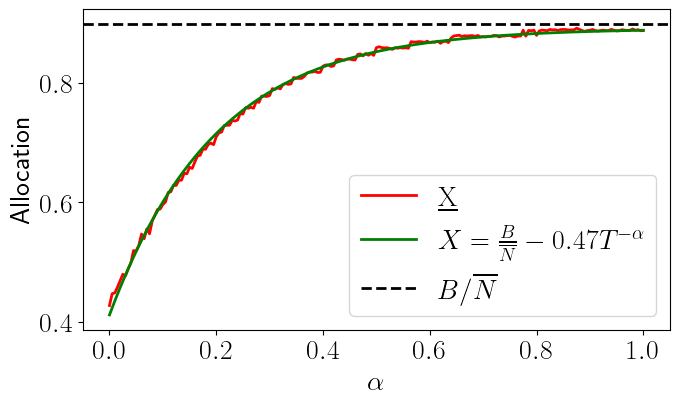

In [13]:
eps_val = 0.1

plt.style.use('PaperDoubleFig.mplstyle.txt')
plt.rc('text.latex', preamble=r'\usepackage{amsfonts}')
plt.rc('text', usetex=True)


# Make some style choices for plotting 
sns.lineplot(x='Alpha', y='Value', data=df, color='red', linewidth=2, 
            ci = None, label=r'$\mathrm{\underline{X}}$')
# lower_bound = 1 - 3 * n * (n)**((-1)*(1+alpha_grid)) - ((1/n) * np.log(3*n*np.log(n)))
# fit_bound = 0.9 - 0.9*n * (n)**((-1)*(1+alpha_grid))
plt.axhline(y=x_lower_no_perish, color='k', linestyle='--')

custom_legend_entry = Line2D([0], [0], color='k', linestyle='--', label='$B/\overline{N}$')

plt.plot(alpha_grid, func(alpha_grid, *params), color='g', linewidth=2, label=r'$X = \frac{B}{\overline{N}} - 0.47 T^{-\alpha}$')


handles, labels = plt.gca().get_legend_handles_labels()
handles.append(custom_legend_entry)
labels.append(r'$B/\overline{N}$')

plt.legend(handles=handles, labels=labels)




axs = plt.gca()

# axs.get_legend().remove() 
axs.set_ylabel(r'Allocation')
axs.set_xlabel(r'$\alpha$')

plt.savefig('./figures/'+file_name+'.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)
plt.show()


In [ ]:
)_